In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5", temperature=0)

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY:  ········


In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Doctor(BaseModel):
    name: str = Field(
        description="Name of the doctor."
    )
    qualifications: str = Field(
        description="Qualifications of the doctor",
    )
    specialization: str = Field(
        description="Specialization of the dcotor i.e., cardiologist, dermatologist, orthopedist, etc.",
    )
    experience: int = Field(
        description="Number of years of work experience of the doctor"
    )
    description: str = Field(
        description="Description of the doctor's place of work, achievements, etc.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nQualifications: {self.qualifications}\nSpecialization: {self.specialization}\nExperience: {self.experience}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    doctors: List[Doctor] = Field(
        description="Comprehensive list of doctors with their specializations, place of work and qualifications.",
    )

class GenerateDoctorsState(TypedDict):
    symptom: str 
    max_doctors: int 
    human_feedback: str 
    doctors: List[Doctor]

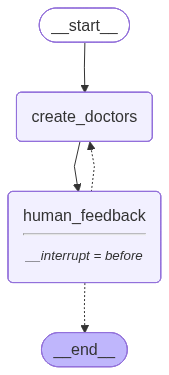

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

doctor_instructions="""You are tasked with creating a set of Doctors. Follow these instructions carefully:

1. First, take a look at the symptom: {symptom}
        
2. Examine any feedback that has been optionally provided to guide creation of the doctor personas: 
        
{human_feedback}
    
3. Determine the most suitable specialists who can diagnose the symptom {symptom}.
                    
4. Pick the top {max_doctors} specialists most suited for the symptom {symptom}.

5. Assign one doctor for each specialization."""

def create_doctors(state: GenerateDoctorsState):
    
    """ Create doctors """
    
    symptom=state['symptom']
    max_doctors=state['max_doctors']
    human_feedback=state.get('human_feedback', '')
        
    structured_llm = llm.with_structured_output(Perspectives)

    system_message = doctor_instructions.format(symptom=symptom,
                                                            human_feedback=human_feedback, 
                                                            max_doctors=max_doctors)
 
    doctors = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the list of doctors.")])


    return {"doctors": doctors.doctors}

def human_feedback(state: GenerateDoctorsState):
    """ No-op node that should be interrupted on """
    pass



def should_continue(state):
    messages = state.get("messages", [])
    if not messages:
        # No messages yet, decide default behavior
        return END  # or "create_doctors" if you want to loop
    last_message = messages[-1].get("content", "").lower()
    if "thank you" in last_message:
        return END
    elif len(messages) >= state.get("max_num_turns", 15):
        return END
    else:
        return "create_doctors"
 
builder = StateGraph(GenerateDoctorsState)
builder.add_node("create_doctors", create_doctors)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_doctors")
builder.add_edge("create_doctors", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_doctors", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Creating a list of doctors
max_doctors = 3 
symptom = "I am having a pain in my lungs"
thread = {"configurable": {"thread_id": "1"}}
doctors=()
for event in graph.stream({"symptom":symptom,"max_doctors":max_doctors,}, thread, stream_mode="values"):
    doctors = event.get('doctors', '')
    if doctors:
        for doctor in doctors:
            print(f"Name: {doctor.name}")
            print(f"Experience(in years): {doctor.experience}")
            print(f"Qualification: {doctor.qualifications}")
            print(f"Specialization: {doctor.specialization}")
            print(f"Description: {doctor.description}")
            print("-" * 50)  

Name: Dr. Aisha Rahman
Experience(in years): 14
Qualification: MD, FCCP
Specialization: Pulmonologist
Description: Consultant Pulmonologist at City Respiratory & Sleep Center. Focuses on pleuritic chest pain, pneumonia, pulmonary embolism workups, and interventional bronchoscopy. Leads a multidisciplinary lung clinic and has authored guidelines on outpatient evaluation of pleuritic chest pain.
--------------------------------------------------
Name: Dr. Michael Chen
Experience(in years): 12
Qualification: MD, FACEP
Specialization: Emergency Medicine Physician
Description: Attending physician in the Emergency Department at Metropolitan General Hospital. Expert in rapid assessment of acute chest and lung pain, including pneumothorax, pulmonary embolism, rib fractures, and pneumonia. Trained in point-of-care ultrasound and advanced cardiac life support protocols.
--------------------------------------------------
Name: Dr. Sofia Alvarez
Experience(in years): 16
Qualification: MD, FACC
Spe

In [7]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [8]:
graph.update_state(thread, {"human_feedback": 
                            "Add a Lung cancer specialist"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ceda7-3817-6762-8002-b6bfb6ebd654'}}

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    doctors = event.get('doctors', '')
    if doctors:
        for doctor in doctors:
            print(f"Name: {doctor.name}")
            print(f"Experience(in years): {doctor.experience}")
            print(f"Qualification: {doctor.qualifications}")
            print(f"Specialization: {doctor.specialization}")
            print(f"Description: {doctor.description}")
            print("-" * 50)

Name: Dr. Aisha Rahman
Experience(in years): 14
Qualification: MD, FCCP
Specialization: Pulmonologist
Description: Consultant Pulmonologist at City Respiratory & Sleep Center. Focuses on pleuritic chest pain, pneumonia, pulmonary embolism workups, and interventional bronchoscopy. Leads a multidisciplinary lung clinic and has authored guidelines on outpatient evaluation of pleuritic chest pain.
--------------------------------------------------
Name: Dr. Michael Chen
Experience(in years): 12
Qualification: MD, FACEP
Specialization: Emergency Medicine Physician
Description: Attending physician in the Emergency Department at Metropolitan General Hospital. Expert in rapid assessment of acute chest and lung pain, including pneumothorax, pulmonary embolism, rib fractures, and pneumonia. Trained in point-of-care ultrasound and advanced cardiac life support protocols.
--------------------------------------------------
Name: Dr. Sofia Alvarez
Experience(in years): 16
Qualification: MD, FACC
Spe

In [10]:
further_feedack = None
graph.update_state(thread, {"human_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ceda7-3863-63aa-8003-21cd667d725d'}}

In [11]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [12]:
final_state = graph.get_state(thread)
doctors = final_state.values.get('doctors')

In [13]:
final_state.next

()

In [14]:
for doctor in doctors:
    print(f"Name: {doctor.name}")
    print(f"Experience(in years): {doctor.experience}")
    print(f"Qualification: {doctor.qualifications}")
    print(f"Specialization: {doctor.specialization}")
    print(f"Description: {doctor.description}")
    print("-" * 50) 

Name: Dr. Aisha Rahman
Experience(in years): 14
Qualification: MD, FCCP
Specialization: Pulmonologist
Description: Consultant Pulmonologist at City Respiratory & Sleep Center. Focuses on pleuritic chest pain, pneumonia, pulmonary embolism workups, and interventional bronchoscopy. Leads a multidisciplinary lung clinic and has authored guidelines on outpatient evaluation of pleuritic chest pain.
--------------------------------------------------
Name: Dr. Michael Chen
Experience(in years): 12
Qualification: MD, FACEP
Specialization: Emergency Medicine Physician
Description: Attending physician in the Emergency Department at Metropolitan General Hospital. Expert in rapid assessment of acute chest and lung pain, including pneumothorax, pulmonary embolism, rib fractures, and pneumonia. Trained in point-of-care ultrasound and advanced cardiac life support protocols.
--------------------------------------------------
Name: Dr. Sofia Alvarez
Experience(in years): 16
Qualification: MD, FACC
Spe

In [15]:
# planning on arriving at result with the help of debates between the professionals.
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class DebateState(MessagesState):
    max_num_turns: int 
    context: Annotated[list, operator.add] 
    doctors: list
    debate: str 
    sections: list 

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [16]:
debate_instructions = """You are to initiate a discussion between multiple doctors to diagnose the given symptom. 

Your goal is to get all of them to justify their approach and try to convince the other doctors why their way is the best. Be open to all ideas and decide the best way.

1. Take turns: Have a back and forth with the other specialists on how to diagnose and treat the symptom.
        
2. Specific: Insights that avoid generalities and include specific knowledge from each induviduals field.

Here is your topic of focus and set of goals for each doctor: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then make your case.

Continue to ask questions to drill down and refine your treatment plan for the patient.

You are to make judgments based on just the symptoms of the patient, if there is any uncertainty (i.e. gender, age, history), you are to provide answers for all cases to be as all-encompassing as possible
        
When you are satisfied with your plan, complete the debate with: "Thank you!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_discussion(state: DebateState):
    """ Node to generate a discussion """

    doctors = state["doctors"]
    messages = state["messages"]
 
    system_message = debate_instructions.format(goals={doctor1.persona,doctor2.persona,doctor3.persona})
    sentence = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    return {"messages": [sentence]}

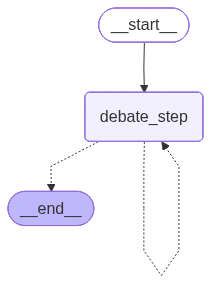

In [17]:
# testing out a smaple debate by making a temporary graph for debate

builder = StateGraph(DebateState)

builder.add_node("debate_step", generate_discussion)
builder.add_edge(START, "debate_step")
def should_continue(state):
    # stop if "Thank you!" appears OR turns exceeded
    last_message = state["messages"][-1].content.lower()

    if "thank you" in last_message:
        return END
    if len(state["messages"]) >= state["max_num_turns"]:
        return END
    return "debate_step"
builder.add_conditional_edges(
    "debate_step",
    should_continue,
    ["debate_step", END]
)

memory = MemorySaver()
graph = builder.compile(interrupt_before=[], checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [18]:
# Input
doctor1=doctors[0]
doctor2=doctors[1]
doctor3=doctors[2]
max_num_turns = 15
topic = "Treating the symptom"
thread = {"configurable": {"thread_id": "2"}}
initial_state = {
    "messages": [
        {"role": "user", "content": "The patient has pleuritic chest pain and cough."}
    ],
    "doctors": doctors,
    "context": [],
    "max_num_turns": max_num_turns,
    "debate": topic,
    "sections": []
}


for event in graph.stream(initial_state, thread, stream_mode="values"):
    if "messages" in event:
        print("\n----------------------------------------------")
        print(event["messages"][-1].content)


----------------------------------------------
The patient has pleuritic chest pain and cough.

----------------------------------------------
I’m Dr. Michael Chen, Emergency Medicine. Pleuritic chest pain with cough makes me immediately consider pulmonary embolism (PE), pneumonia, pneumothorax, viral pleurisy, and pericarditis; I also won’t ignore atypical ACS. My ED-first moves are rapid and specific:
- Triage: ABCs, O2 sat, heart rate, blood pressure, temperature, respiratory rate. Place on a monitor and give supplemental O2 if SpO2 < 92%.
- Tests in the first 10 minutes: 12‑lead ECG, bedside lung/heart ultrasound (look for absent lung sliding/“barcode” for pneumothorax, B‑lines or consolidation for pneumonia, right heart strain, and pericardial effusion), chest X‑ray, high‑sensitivity troponin, CBC, BMP, CRP, and viral panel (COVID/flu/RSV). Pregnancy test if relevant.
- Risk stratify for PE using history + exam. If low pretest probability and PERC negative, no D‑dimer; otherwise 

In [19]:
# integration of web search

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

TAVILY_API_KEY:  ········


In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

C:\Users\hp\AppData\Local\Temp\ipykernel_32532\3381304624.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [21]:
from langchain_community.document_loaders import WikipediaLoader

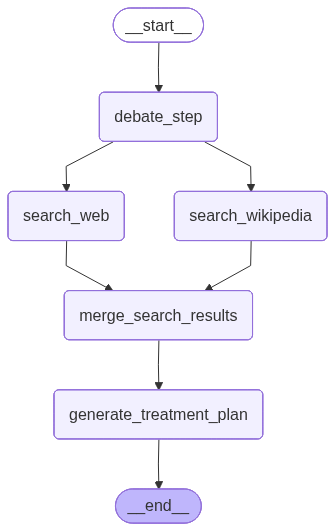

In [22]:
from langchain_core.messages import get_buffer_string

search_instructions = SystemMessage(content=f"""You will be given a conversation between medical experts diagnosing a symptom. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the treatment plan posed by each doctor.

Verify this final plan using a well-structured web search query""")

def search_web(state: DebateState):

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])

    search_docs = tavily_search.invoke(search_query.search_query)

    if isinstance(search_docs, dict) and "results" in search_docs:
        search_docs = search_docs["results"]

    formatted = []

    for doc in search_docs:
        if isinstance(doc, dict):
            url = doc.get("url", "unknown")
            content = doc.get("content", str(doc))
            formatted.append(
                f'<Document href="{url}">\n{content}\n</Document>'
            )
        else:
            formatted.append(
                f'<Document>\n{str(doc)}\n</Document>'
            )

    return {"context": ["\n\n---\n\n".join(formatted)]}


def search_wikipedia(state: DebateState):
    
    """ Retrieve docs from wikipedia """

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=3).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def merge_search_results(state: DebateState):
    merged = "\n\n".join(state["context"])
    return {"context": [merged]}

def generate_treatment_plan(state: DebateState):
    """
    Node that merges:
    - all debate conversation
    - web + wikipedia search context
    and generates a final, unified medical treatment plan.
    """

    messages = state["messages"]            
    context_list = state.get("context", []) 
    debate_topic = state.get("debate", "")  
    
    context_text = "\n\n".join(context_list) if context_list else "No external context available."
    
    system_message = """You are a panel lead physician tasked with producing the *final medical treatment plan based on:

    1. The entire debate between specialists.
    2. The combined search context (clinical guidelines, web results, wikipedia summaries).
    3. The patient’s main complaint: {debate_topic}

    Your output must be:

    - Structured
    - Evidence-based
    - Reflective of the discussion points raised by all specialists
    - Clear and clinically actionable

    DO NOT repeat the debate.
    DO NOT repeat the search results.
    Synthesize everything into a **single, authoritative treatment plan**.

    Include:
    - Primary diagnosis or differential
    - Recommended diagnostic tests with justification
    - Initial treatment
    - Follow-up considerations
    - Any red flags or escalation scenarios

Finish with: “Final plan complete.”
"""

    final_response = llm.invoke([SystemMessage(content=system_message)] + messages)
    final_response.name = "treatment_plan"

    return {"messages": [final_response]}




# Add nodes and edges 
debate_builder = StateGraph(DebateState)
debate_builder.add_node("debate_step", generate_discussion)
debate_builder.add_node("search_web", search_web)
debate_builder.add_node("search_wikipedia", search_wikipedia)
debate_builder.add_node("merge_search_results", merge_search_results)
debate_builder.add_node("generate_treatment_plan", generate_treatment_plan)

# Flow
debate_builder.add_edge(START, "debate_step")
debate_builder.add_edge("debate_step", "search_web")
debate_builder.add_edge("debate_step", "search_wikipedia")
debate_builder.add_edge("search_web", "merge_search_results")
debate_builder.add_edge("search_wikipedia", "merge_search_results")
debate_builder.add_edge("merge_search_results", "generate_treatment_plan")
debate_builder.add_edge("generate_treatment_plan", END)

# debate 
memory = MemorySaver()
debate_graph = debate_builder.compile(checkpointer=memory).with_config(run_name="Conduct Debate")

# View
display(Image(debate_graph.get_graph().draw_mermaid_png()))

In [23]:
# Input
doctor1=doctors[0]
doctor2=doctors[1]
doctor3=doctors[2]
max_num_turns = 15
topic = "Treating the symptom"
thread = {"configurable": {"thread_id": "2"}}
initial_state = {
    "messages": [
        {"role": "user", "content": "The patient has pleuritic chest pain and cough."}
    ],
    "doctors": doctors,
    "context": [],
    "max_num_turns": max_num_turns,
    "debate": topic,
    "sections": []
}


final_plan = None

for event in debate_graph.stream(initial_state, thread, stream_mode="values"):
    if "messages" in event:
        msg = event["messages"][-1]

        if getattr(msg, "name", None) == "treatment_plan":
            final_plan = msg.content

# Print only the final treatment plan
print(final_plan)


Final treatment plan for pleuritic chest pain with cough

1) Working diagnosis and prioritized differential
- Time-sensitive conditions to rule out first:
  - Pulmonary embolism (PE)
  - Pneumothorax
  - Community-acquired pneumonia (CAP) with/without parapneumonic effusion/empyema
  - Acute pericarditis or myopericarditis
- Other likely benign causes (only after excluding above):
  - Viral pleuritis
  - Costochondritis/rib strain

2) Diagnostic testing and justification
Immediate (within minutes)
- Vitals with pulse oximetry; consider arterial/venous blood gas if hypoxic or in distress.
- 12‑lead ECG: exclude ischemia; identify pericarditis patterns; assess for right heart strain (possible PE).
- Chest X‑ray (PA/lateral if stable; portable if unstable): look for consolidation, effusion, pneumothorax, alternative causes.
- Point‑of‑care ultrasound (POCUS): assess lung sliding (pneumothorax), focal B‑lines/consolidation (pneumonia), pleural effusion; cardiac views for pericardial effusi

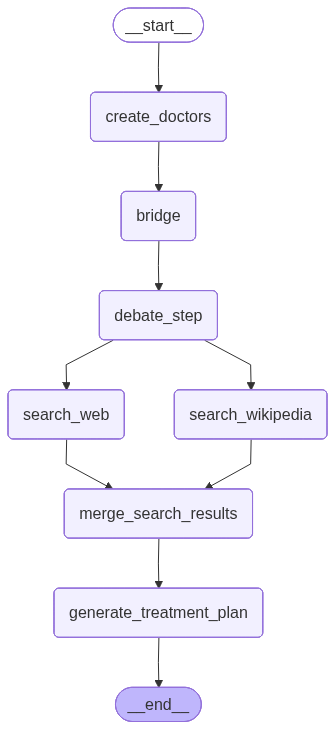

In [24]:
from dataclasses import dataclass, field
@dataclass
class FinalState:
    symptom: str 
    max_doctors: int  
    doctors: List[Doctor]
    max_num_turns: int 
    context: Annotated[list, operator.add] 
    doctors: list
    debate: str 
    sections: list
    

def bridge(FinalState):
    return FinalState

full_builder = StateGraph(FinalState)
full_builder.add_node("create_doctors", create_doctors)
#full_builder.add_node("human_feedback", human_feedback)

full_builder.add_node("bridge",bridge)

full_builder.add_node("debate_step", generate_discussion)
full_builder.add_node("search_web", search_web)
full_builder.add_node("search_wikipedia", search_wikipedia)
full_builder.add_node("merge_search_results", merge_search_results)
full_builder.add_node("generate_treatment_plan", generate_treatment_plan)

# Flow
full_builder.add_edge(START, "create_doctors")
full_builder.add_edge("create_doctors", "bridge")
#full_builder.add_conditional_edges("human_feedback", should_continue, ["create_doctors", "bridge"])



full_builder.add_edge("bridge", "debate_step")
full_builder.add_edge("debate_step", "search_web")
full_builder.add_edge("debate_step", "search_wikipedia")
full_builder.add_edge("search_web", "merge_search_results")
full_builder.add_edge("search_wikipedia", "merge_search_results")
full_builder.add_edge("merge_search_results", "generate_treatment_plan")
full_builder.add_edge("generate_treatment_plan", END)

# debate 
memory = MemorySaver()
final_graph = full_builder.compile(checkpointer=memory).with_config(run_name="Full run")

# View
display(Image(final_graph.get_graph().draw_mermaid_png()))

In [26]:
# Input
symptom=input("Enter symptom")
max_doctors=3
doctors=[]
max_num_turns = 15
topic = "Treating the symptom"
thread = {"configurable": {"thread_id": "5"}}
initial_state = {
    "messages": [
        {"role": "user", "content": symptom}
    ],
    "symptom": symptom,
    "max_doctors": max_doctors,
    "doctors": doctors,
    "context": [],
    "max_num_turns": max_num_turns,
    "debate": topic,
    "sections": []
}

final_plan = None
final_state = None

for event in final_graph.stream(initial_state, thread, stream_mode="values"):
    final_state = event


print(final_state.keys())
print(final_state['doctors'])
print(final_state['messages'])



Enter symptom I have ear ache


dict_keys(['symptom', 'max_doctors', 'doctors', 'max_num_turns', 'context', 'debate', 'sections', 'messages'])
[Doctor(name='Dr. Maya R. Chen', qualifications='MD, FACS (Otolaryngology—Head & Neck Surgery)', specialization='Otolaryngologist (ENT)', experience=14, description='Board-certified otolaryngologist at Metropolitan Ear, Nose & Throat Center. Manages acute and chronic ear pain, otitis media/externa, Eustachian tube dysfunction, and perforated eardrums. Leads a same-day ear pain clinic and has published on topical therapies for swimmer’s ear.'), Doctor(name='Dr. Arjun K. Patel', qualifications='MD, Fellowship in Otology/Neurotology', specialization='Otologist/Neurotologist', experience=12, description='Subspecialized ear surgeon at University Hearing & Balance Institute. Expertise in chronic ear infections, cholesteatoma, tympanoplasty, mastoid surgery, and complex otalgia with associated hearing or balance issues. Runs a multidisciplinary ear clinic for difficult cases.'), Doct

In [28]:
symptom=input("Enter symptom")
max_doctors=3
doctors=[]
max_num_turns = 15
topic = "Treating the symptom"
thread = {"configurable": {"thread_id": "5"}}
initial_state = {
    "messages": [
        {"role": "user", "content": symptom}
    ],
    "symptom": symptom,
    "max_doctors": max_doctors,
    "doctors": doctors,
    "context": [],
    "max_num_turns": max_num_turns,
    "debate": topic,
    "sections": []
}

final_state = None

for event in final_graph.stream(initial_state, thread, stream_mode="values"):
    final_state = event


print(final_state.keys())
print(final_state['doctors'])
print(final_state['messages'])

Enter symptom I have back pain


dict_keys(['symptom', 'max_doctors', 'doctors', 'max_num_turns', 'context', 'debate', 'sections', 'messages'])
[Doctor(name='Dr. Maya Deshmukh', qualifications='MD, FAAOS; Fellowship in Spine Surgery', specialization='Orthopedist (Spine Surgeon)', experience=15, description='Board-certified orthopedic spine surgeon focusing on degenerative spine conditions, herniated discs, and spinal stenosis. Leads a multidisciplinary spine clinic and emphasizes evidence-based conservative care with minimally invasive options when needed.'), Doctor(name='Dr. Samuel Park', qualifications='MD, FAAPMR; Fellowship in Interventional Spine & Pain', specialization='Physiatrist (Physical Medicine & Rehabilitation)', experience=12, description='Board-certified physiatrist specializing in nonoperative back pain management, therapeutic exercise, EMG/NCS, and image-guided spine injections. Coordinates comprehensive rehab programs with physical therapy and ergonomics counseling.'), Doctor(name='Dr. Aisha Rahman',